# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import SGDRegressor,ElasticNet,RidgeCV, LinearRegression
from sklearn.feature_selection import RFE,RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, KFold, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from genetic_selection import GeneticSelectionCV


import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, BatchNormalization, Input, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()
tf.keras.backend.set_floatx('float64')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12953533441543562105
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1392574849458448916
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3127299276
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6320338885461868221
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11369456147563490845
physical_device_desc: "device: XLA_GPU device"
]


# Feature Selection

## RFE

In [2]:
def get_genes_RFE(X,y,estimators,num_genes_fold,num_genes_final,folds,genes):
    genes_related = []
    
    for estimator in estimators:
        selector = RFECV(estimator, min_features_to_select=num_genes_fold, cv=folds, step=1)
        selector = selector.fit(X, y)
        ranking = selector.ranking_
        ranking_idx = ranking.argsort()[-num_genes_fold:][::-1]
        genes_related+=list(X.columns[ranking_idx])

    dic_count = Counter(genes_related)
    dic_count = {k: v for k, v in sorted(dic_count.items(), key=lambda item: item[1])}
    top_genes = list(dic_count.keys())[-num_genes_final:]
    return top_genes



## Deep Learning

In [3]:
def get_genes_dl(X,y,test_size,num_genes_final,genes):
    
    input_size = X.shape[1]
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size)
    
    model = Sequential()
    activation_dense = 'relu'
    model.add(Dense(X.shape[1], activation=activation_dense)) 
#     model.add(Dropout(0.5))
    model.add(Dense(256, activation=activation_dense)) 
#     model.add(Dropout(0.5))
    model.add(Dense(128, activation=activation_dense))
#     model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    hist= model.fit( X_train, 
                     y_train, 
                     batch_size=32, 
                     epochs=epochs, 
                     shuffle='True', 
                     validation_data=(X_test, y_test),
                     verbose=0)
    # get the first layer weights.
    weights = model.layers[1].get_weights()[0]

    # get the feature importance.
    importance = weights.sum(axis = 1)
    imp_idx = np.argsort(importance)[-num_genes_final:]
    genes_dl = list(genes[imp_idx])
    return genes_dl

## Genetic Algorithms

In [5]:
def get_genes_ga(X,y,model,test_size,num_genes_final):
    
    selection = GeneticSelectionCV(model,
                                  cv=folds,
                                  scoring="accuracy",
                                  max_features=num_genes_final,
                                  n_population=100,
                                  crossover_proba=0.5,
                                  mutation_proba=0.2,
                                  n_generations=50,
                                  crossover_independent_proba=0.5,
                                  mutation_independent_proba=0.05)

    # fit the GA search to our data.
    selection = selection.fit(X, y)

    # print the results.
    print(selection.support_)

# model = RandomForestClassifier(n_estimators=231)
    
# get_genes_ga(X,y,model,test_size,num_genes_final)

## Comparison

In [8]:
epochs = 30
test_size = 0.3 
num_genes_fold = 15
num_genes_final = 8
folds = 10

estimators = [SVR(kernel='linear'),
              SGDRegressor(),
              ElasticNet(),
              RidgeCV(),
              LinearRegression()]

model = RandomForestClassifier(n_estimators=231)

events = os.listdir('Dados/Eventos adversos')
for event in events:
    dados = pd.read_csv(f'Dados/Eventos adversos/{event}')
    X = dados.iloc[:,:-1]
    y = dados.iloc[:,-1]
    genes = X.columns
    genes_ml = get_genes_RFE(X,y,estimators,num_genes_fold,num_genes_final,folds,genes)
    X = np.array(X)
    y = np.array(y)
    y = y.reshape((y.shape[0],1))
    genes_dl = get_genes_dl(X,y,test_size,num_genes_final,genes)
    print(f'Event: {event[:-4]}\nGenes selected by RFE:{genes_ml}\nGenes selectred by MLP:{genes_dl}\n')

Event: Arthralgia
Genes selected by RFE:['TLR9', 'GBP2', 'EGF', 'IL6', 'CCL3', 'TGFBR2', 'CLEC7A', 'CXCL13']
Genes selectred by MLP:['IFI6', 'IL15', 'TBX21', 'CD209', 'IL22RA1', 'NLRP2', 'GBP2', 'NCAM1']

Event: Arthritis
Genes selected by RFE:['EGF', 'IFITM3', 'IFI6', 'GBP2', 'FPR1', 'FOXP3', 'GATA3', 'GBP5']
Genes selectred by MLP:['NLRP3', 'CLEC7A', 'CD274', 'NLRP2', 'DSE', 'TLR9', 'NCAM1', 'GBP5']

Event: Chills
Genes selected by RFE:['SOCS1', 'IL15', 'EGF', 'IFI44L', 'FPR1', 'CD274', 'TBX21', 'GBP2']
Genes selectred by MLP:['IFIT3', 'KIF1B', 'GBP2', 'GBP5', 'TBX21', 'TAGAP', 'IL22RA1', 'IL5']

Event: Fatigue
Genes selected by RFE:['IFITM3', 'DSE', 'CD209', 'TLR9', 'EGF', 'CCL11', 'FOXP3', 'IFI44L']
Genes selectred by MLP:['IFI44L', 'FOXP3', 'NLRP2', 'NCAM1', 'NEDD4L', 'EGF', 'OAS1', 'MRC2']

Event: Fever
Genes selected by RFE:['IFIT3', 'GATA3', 'GBP2', 'GBP5', 'TGFBR2', 'CLEC7A', 'FPR1', 'CD274']
Genes selectred by MLP:['IFI44', 'GATA3', 'GBP5', 'CXCL9', 'CD209', 'IL15', 'IFI6', '

# Classification

## Ajuste de hiperparâmetros

In [9]:
def get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid, model,w,h,df,plot,annot):
    
    gs = GridSearchCV(estimator=model,
                      param_grid=param_grid,
                      cv=kfold)
    best_gs = gs.fit(X_train,y_train)
    n = len(param_grid)
    scores = best_gs.cv_results_['mean_test_score']
    scores = scores.reshape(len(scores),)
    
    if n == 1:
        label = list(param_grid.keys())[0]
        par = list(param_grid.values())[0]
        plt.plot(par,scores)
        plt.ylabel('F1-score')
        plt.xlabel(label)
        plt.show()
        
    if n == 2:
        
        label1,label2 = param_grid.keys()
        par1,par2 = param_grid.values()
        scores_df = pd.DataFrame(columns=par1,index=par2)
        for i in range(len(par1)*len(par2)):
            col = i % len(par1)
            row = i // len(par1)
            scores_df.iloc[row,col] = scores[i]

        scores_df = scores_df.astype(float)
        if df:
            print(scores_df)
        if plot:
            fig= plt.figure(figsize=(w,h))
            heatmap = sns.heatmap(scores_df,annot=annot)        
            plt.xlabel(label1)
            plt.ylabel(label2)
            plt.show()

    return best_gs.best_params_


## Algorithm

In [10]:
n_splits = 4
test_size = 0.3 #Hp
num_genes_fold = 15
num_genes_final = 5
folds = 10
events = os.listdir('Dados/Eventos adversos')

metrics_rfe = []
metrics_dl = []

n_folds = 4
test_size = 0.35

kfold = KFold(n_folds,shuffle=True,random_state=42)

max_depth = 20
depths = [i for i in range(1,max_depth+1)]
param_grid = {'max_depth':depths,
              'splitter':['best', 'random'],
              'criterion':['gini','entropy']
             }

# pca = PCA(n_components=num_genes_final)
events_name = []

for event in events:
    dados = pd.read_csv(f'Dados/Eventos adversos/{event}')
    
    X = dados.iloc[:,:-1]
    y = dados.iloc[:,-1]
    genes = X.columns
    
    genes_rfe = get_genes_RFE(X,y,estimators,num_genes_fold,num_genes_final,folds,genes)
    genes_dl = get_genes_dl(X,y,test_size,num_genes_final,genes)
    
    X_dl = X[genes_dl]
    X_rfe = X[genes_rfe]
    
#     X = pd.DataFrame(pca.fit_transform(X))
    
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

    tree_rfe_score = 0.0
    tree_dl_score = 0.0

    for train_index, test_index in sss.split(X, y):    
        X_rfe_train,X_rfe_test,X_dl_train,X_dl_test,y_train,y_test = X_rfe.iloc[train_index],X_rfe.iloc[test_index],X_dl.iloc[train_index],X_dl.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
        
        hp_rfe = get_hiperparams(X_rfe_train,X_rfe_test,y_train,y_test,kfold,param_grid,DecisionTreeClassifier(random_state=42,),10,6,False,False,False)
        criterion_rfe_opt,max_depth_rfe_opt,splitter_rfe_opt = hp_rfe.values()
        #RFE genes
        tree_rfe = make_pipeline(StandardScaler(),
                            DecisionTreeClassifier(random_state=42,
                                                   criterion=criterion_rfe_opt,
                                                   max_depth=max_depth_rfe_opt,
                                                   splitter=splitter_rfe_opt))
        
        tree_rfe.fit(X_rfe_train,y_train)
        pred_rfe_tree = tree_rfe.predict(X_rfe_test)
        tree_rfe_score += f1_score(y_test,pred_rfe_tree,average='weighted',pos_label="Plano ID")
        
        hp_dl = get_hiperparams(X_dl_train,X_dl_test,y_train,y_test,kfold,param_grid,DecisionTreeClassifier(random_state=42,),10,6,False,False,False)
        criterion_dl_opt,max_depth_dl_opt,splitter_dl_opt = hp_dl.values()
        #DL genes
        tree_dl = make_pipeline(StandardScaler(),
                            DecisionTreeClassifier(random_state=42,
                                                   criterion=criterion_dl_opt,
                                                   max_depth=max_depth_dl_opt,
                                                   splitter=splitter_dl_opt))
        
        tree_dl.fit(X_dl_train,y_train)
        pred_dl_tree = tree_rfe.predict(X_dl_test)
        tree_dl_score += f1_score(y_test,pred_dl_tree,average='weighted',pos_label="Plano ID")
        
    
    tree_rfe_score /= float(n_splits)
    tree_rfe_score = round(tree_rfe_score,2)
    
    tree_dl_score /= float(n_splits)
    tree_dl_score = round(tree_dl_score,2)
    
    metrics_rfe.append(tree_rfe_score)
    
    metrics_dl.append(tree_dl_score)
    
    events_name.append(event[:-4])
    
#     print(f"F1-score for {event[:-4]}: RFE : {tree_rfe_score}, DL:{tree_dl_score}")

metrics = pd.DataFrame()
metrics['Genes RFE'] = metrics_rfe
metrics['Genes DL'] = metrics_dl
metrics.index = events_name
metrics

,Genes RFE,Genes DL
Arthralgia,0.69,0.41
Arthritis,0.84,0.35
Chills,0.70,0.42
Fatigue,0.54,0.44
Fever,0.64,0.49
Headache,0.62,0.47
Myalgia,0.57,0.47
Nausea,0.80,0.43


# Classification for presence of events

In [ ]:
dados = pd.read_csv('Dados/dados soma.csv')

X_soma = dados.iloc[:,:-1]
y_soma = dados.iloc[:,-1]

estimators = [SVR(kernel='linear'),
              SGDRegressor(),
              ElasticNet(),
              RidgeCV(),
              LinearRegression()]

n_splits = 4
test_size = 0.3 
num_genes_fold = 15
num_genes_final = 8
folds = 10


# genes = get_genes(X_soma,y_soma,estimators,num_genes_fold,num_genes_final,folds)
# X_soma = X_soma[genes]


n_folds = 4
test_size = 0.35

kfold = KFold(n_folds,shuffle=True,random_state=42)

max_depth = 20
depths = [i for i in range(1,max_depth+1)]
param_grid = {'max_depth':depths,
              'splitter':['best', 'random'],
              'criterion':['gini','entropy']
             }

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

tree_score = 0.0

for train_index, test_index in sss.split(X_soma, y_soma):    
    X_train,X_test,y_train,y_test = X_soma.iloc[train_index],X_soma.iloc[test_index],y_soma.iloc[train_index],y_soma.iloc[test_index]
    hp = get_hiperparams(X_train,X_test,y_train,y_test,kfold,param_grid,DecisionTreeClassifier(random_state=42,),10,6,False,False,False)
    criterion_opt,max_depth_opt,splitter_opt = hp.values()

    #Decision Trees
    tree = make_pipeline(StandardScaler(),
                        DecisionTreeClassifier(random_state=42,
                                               criterion=criterion_opt,
                                               max_depth=max_depth_opt,
                                               splitter=splitter_opt))

    tree.fit(X_train,y_train)
    pred_tree = tree.predict(X_test)
    tree_score += f1_score(y_test,pred_tree,average='weighted',pos_label="Plano ID")

tree_score /= float(n_splits)

tree_score = round(tree_score,2)


print(f"F1-score: Decision Trees: {tree_score*100}%")

## Deep Learning

In [48]:
dados = pd.read_csv('Dados/dados soma.csv')

X_soma = dados.iloc[:,:-1]
y_soma = dados.iloc[:,-1]

n_splits = 4
test_size = 0.3 
num_genes_fold = 15
num_genes_final = 8
folds = 10
epochs = 40
batch_size = 16

# genes = get_genes_RFE(X_soma,y_soma,estimators,num_genes_fold,num_genes_final,folds,genes)
# X_soma = X_soma[genes]
X_soma = np.array(X_soma)
X_soma = X_soma.reshape((X_soma.shape[0],47,3))
y_soma = np.array(y_soma)

input_shape = (47,3)

X_train,X_test,y_train,y_test = train_test_split(X_soma,y_soma,test_size = test_size)
activation = 'relu'
activation_dense = 'relu'

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, padding='same', input_shape=input_shape, activation=activation))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', input_shape=input_shape, activation=activation))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, padding='same', input_shape=input_shape, activation=activation))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation=activation_dense)) 
model.add(Dropout(0.1))
model.add(Dense(512, activation=activation_dense)) 
model.add(Dropout(0.1))
model.add(Dense(1024, activation=activation_dense))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 shuffle='True', 
                 validation_data=(X_test, y_test))

Epoch 1/40
20/20 [==============================] - 0s 22ms/step - loss: 0.6974 - accuracy: 0.4684 - val_loss: 0.6923 - val_accuracy: 0.5147
Epoch 2/40
20/20 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.4905 - val_loss: 0.6923 - val_accuracy: 0.4706
Epoch 3/40
20/20 [==============================] - 0s 13ms/step - loss: 0.6826 - accuracy: 0.5348 - val_loss: 0.6995 - val_accuracy: 0.5588
Epoch 4/40
20/20 [==============================] - 0s 13ms/step - loss: 0.6682 - accuracy: 0.5633 - val_loss: 0.6719 - val_accuracy: 0.5662
Epoch 5/40
20/20 [==============================] - 0s 13ms/step - loss: 0.6209 - accuracy: 0.6424 - val_loss: 0.7187 - val_accuracy: 0.5882
Epoch 6/40
20/20 [==============================] - 0s 14ms/step - loss: 0.5844 - accuracy: 0.6646 - val_loss: 0.7437 - val_accuracy: 0.5147
Epoch 7/40
20/20 [==============================] - 0s 14ms/step - loss: 0.5197 - accuracy: 0.7215 - val_loss: 0.7898 - val_accuracy: 0.6029
Epoch 8/40
20

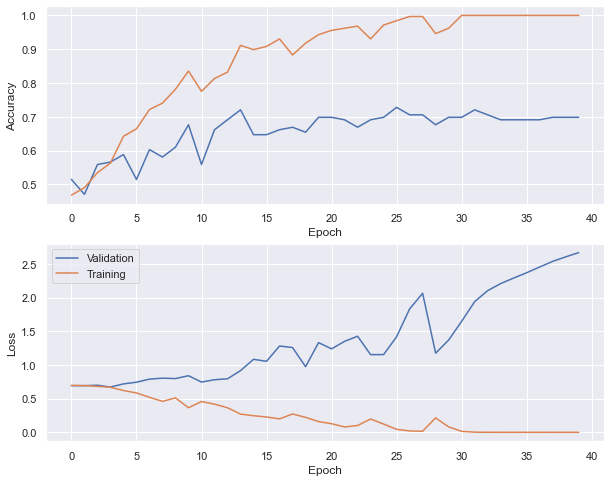

In [49]:
fig,axs=plt.subplots(2)

fig.set_size_inches(10,8)

axs[0].plot(hist.history['val_accuracy'],label='Validation')
axs[0].plot(hist.history['accuracy'],label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[1].plot(hist.history['val_loss'],label='Validation')
axs[1].plot(hist.history['loss'],label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

plt.legend();